# In-situ gyroscope calibration based on accelerometer data

The method for full accelerometer and gyroscope calibration. The method does not depend on any external data sources.

The proposed approach allows to perform full IMU calibration: scale factors, non-orthogonalities and biases of accelerometer and gyroscope triads and misalignment between them.

## Paper
This is the accompanying code for "In-situ gyroscope calibration based on accelerometer data" paper that was presented on 27th Saint Petersburg International Conference on Integrated Navigation Systems (ICINS).

### Citation
If you use the code, the authors will be grateful for citing:
```
@article{mikov2020icins,
  author = {Aleksandr Mikov and Sergey Reginya and Alex Moschevikin},
  title = {{In-situ gyroscope calibration based on accelerometer data}},
  year = {2020}
}
```

## Simulation example

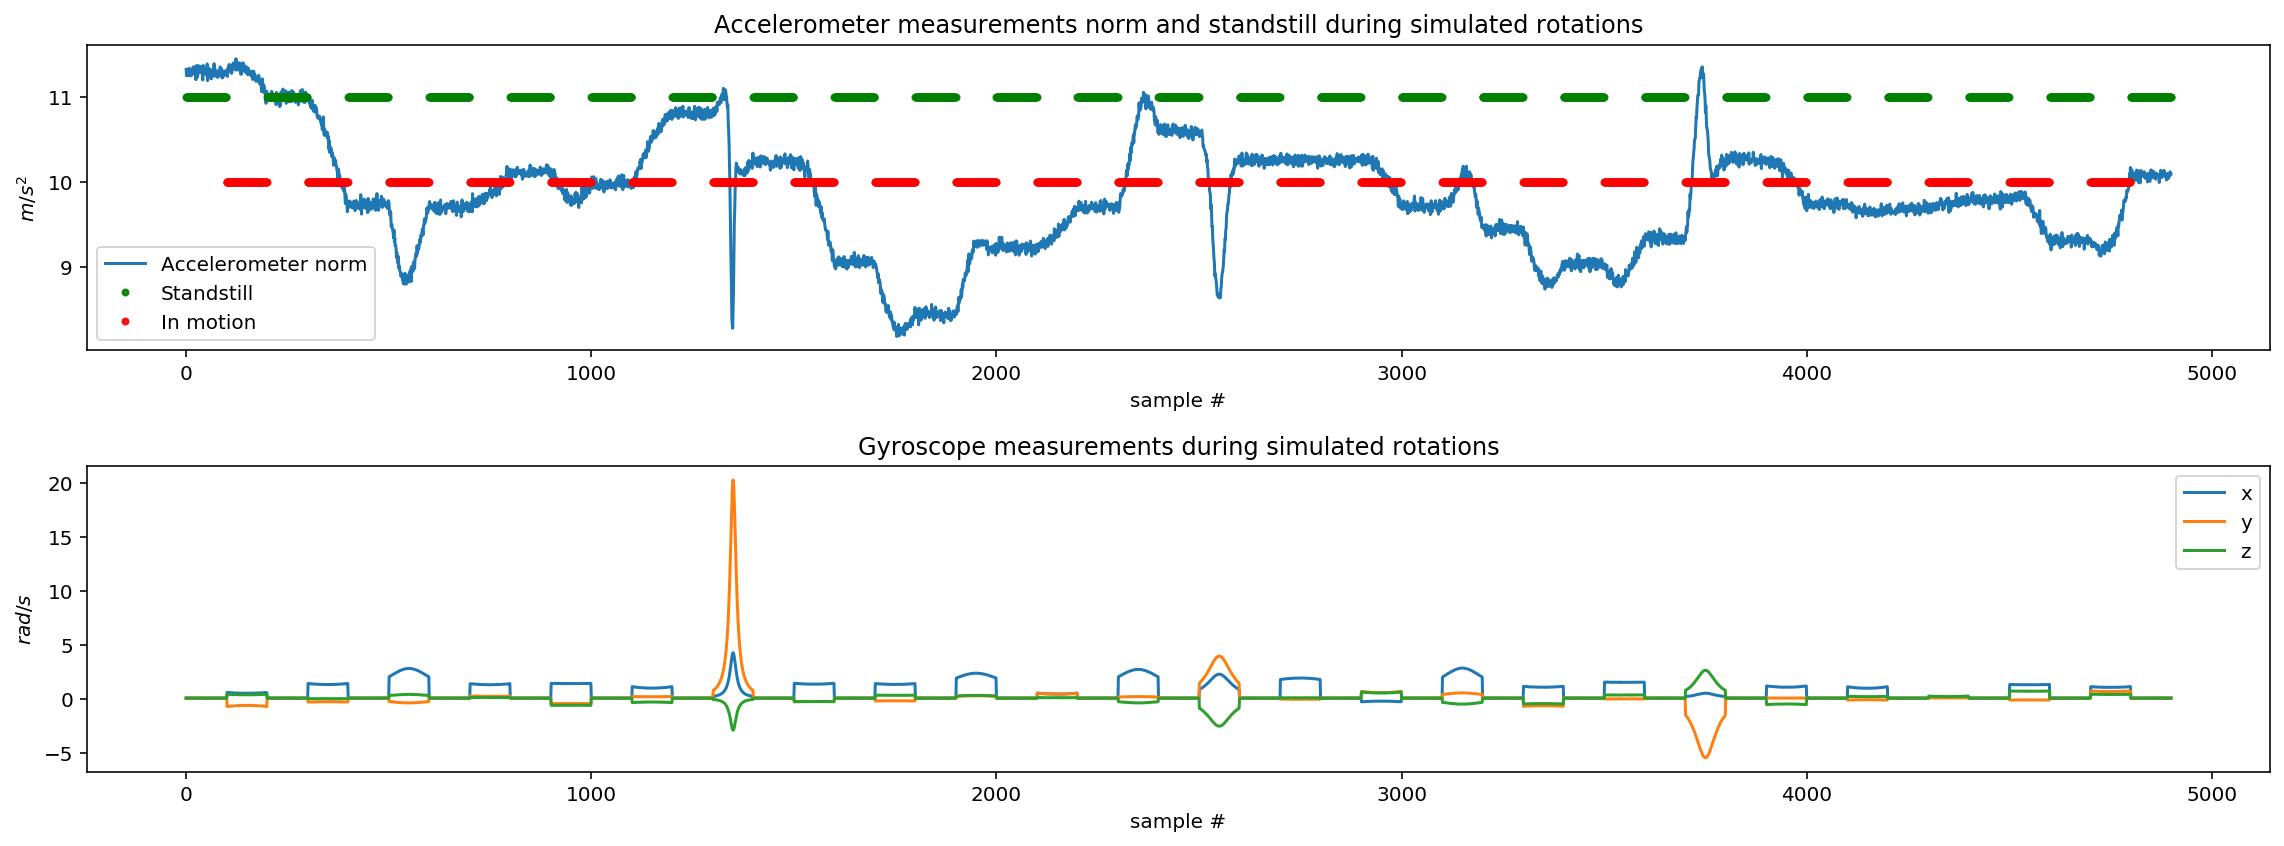

ACC calibration done in:  3.783785581588745 seconds
First row - true parameters, second - their estimate, third - their difference
[ S_X     S_Y     S_Z     NO_X    NO_Y    NO_Z    B_X     B_Y     B_Z   ]
[ 0.0830 -0.0530 -0.0540  0.0950 -0.0200 -0.0610  0.4000 -0.0900 -0.7900]
[ 0.0828 -0.0529 -0.0540  0.0946 -0.0195 -0.0607  0.4003 -0.0926 -0.7906]
[ 0.0002  0.0001  0.0000  0.0004  0.0005  0.0003  0.0003  0.0026  0.0006]


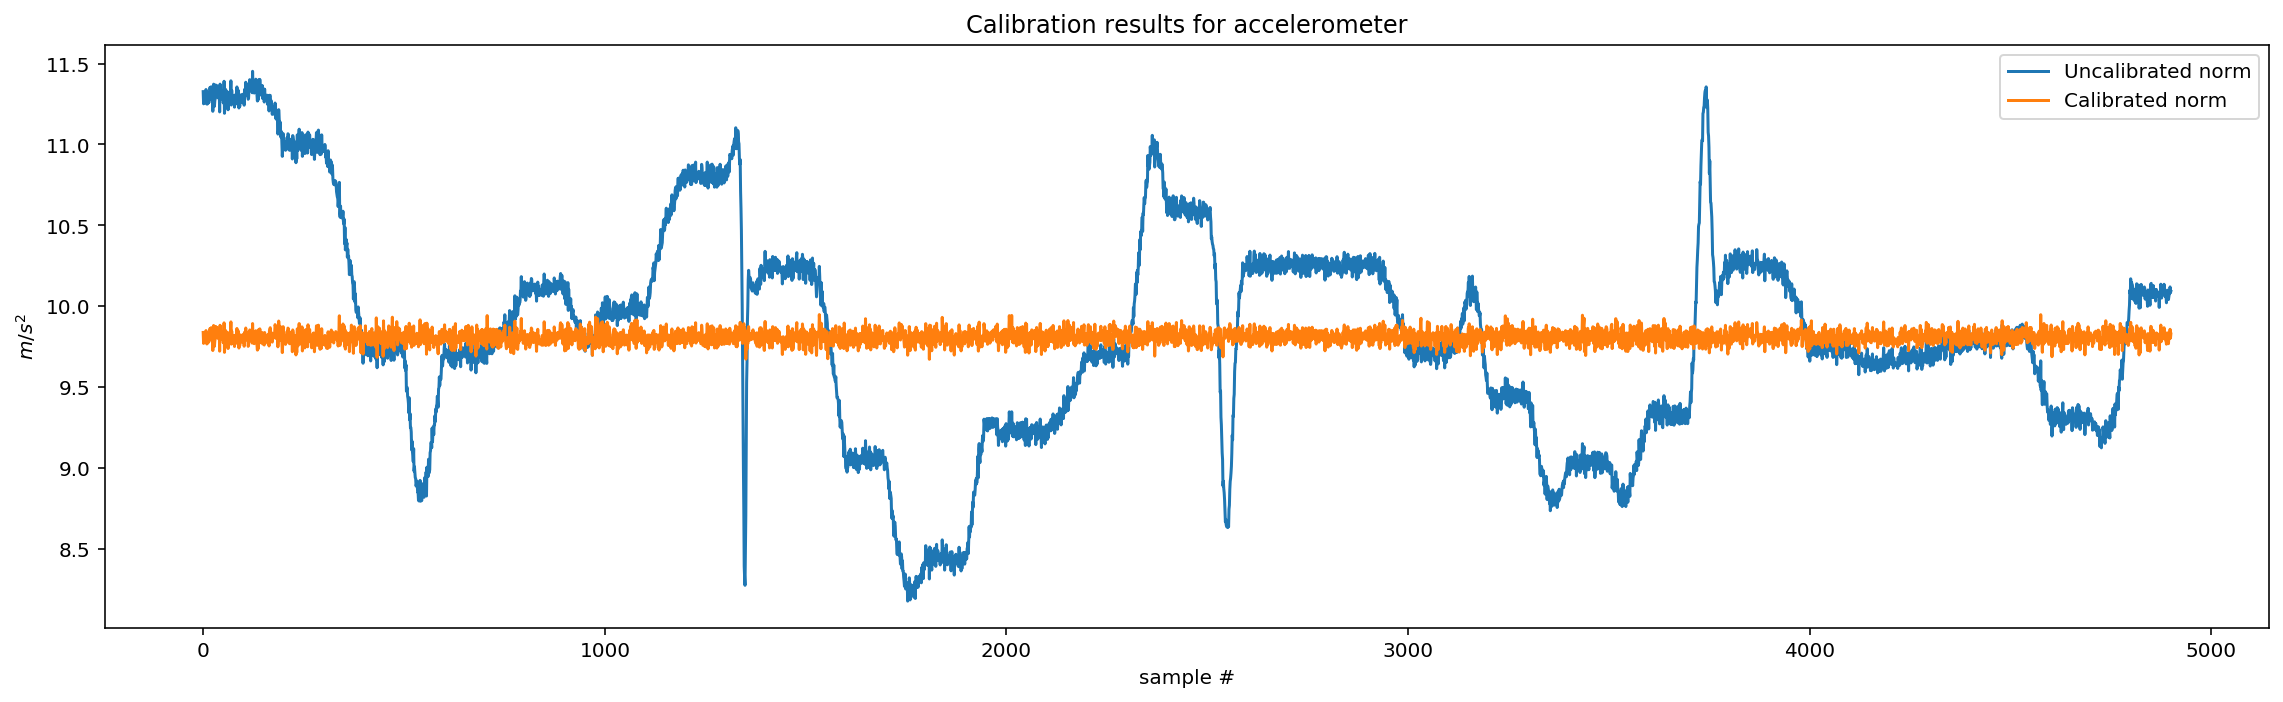

Gyroscope residuals before calibration:  48.69721442377001
Gyroscope residuals with only bias calibrated:  31.330369143206525
GYR calibration done in:  76.9594943523407 seconds
First row - true parameters, second - their estimate, third - their difference
[ S_X     S_Y     S_Z     NO_X    NO_Y    NO_Z    B_X     B_Y     B_Z     E_X     E_Y     E_Z  ]
[ 0.0400 -0.0460 -0.0620  0.0750 -0.0730 -0.0970  0.0880  0.0750  0.0580 -0.0640 -0.0250 -0.0580]
[ 0.0399 -0.0470 -0.0611  0.0738 -0.0727 -0.0967  0.0878  0.0754  0.0584 -0.0646 -0.0250 -0.0586]
[ 0.0001  0.0010  0.0009  0.0012  0.0003  0.0003  0.0002  0.0004  0.0004  0.0006  0.0000  0.0006]
Gyroscope residuals after calibration:  0.0012055899541839167


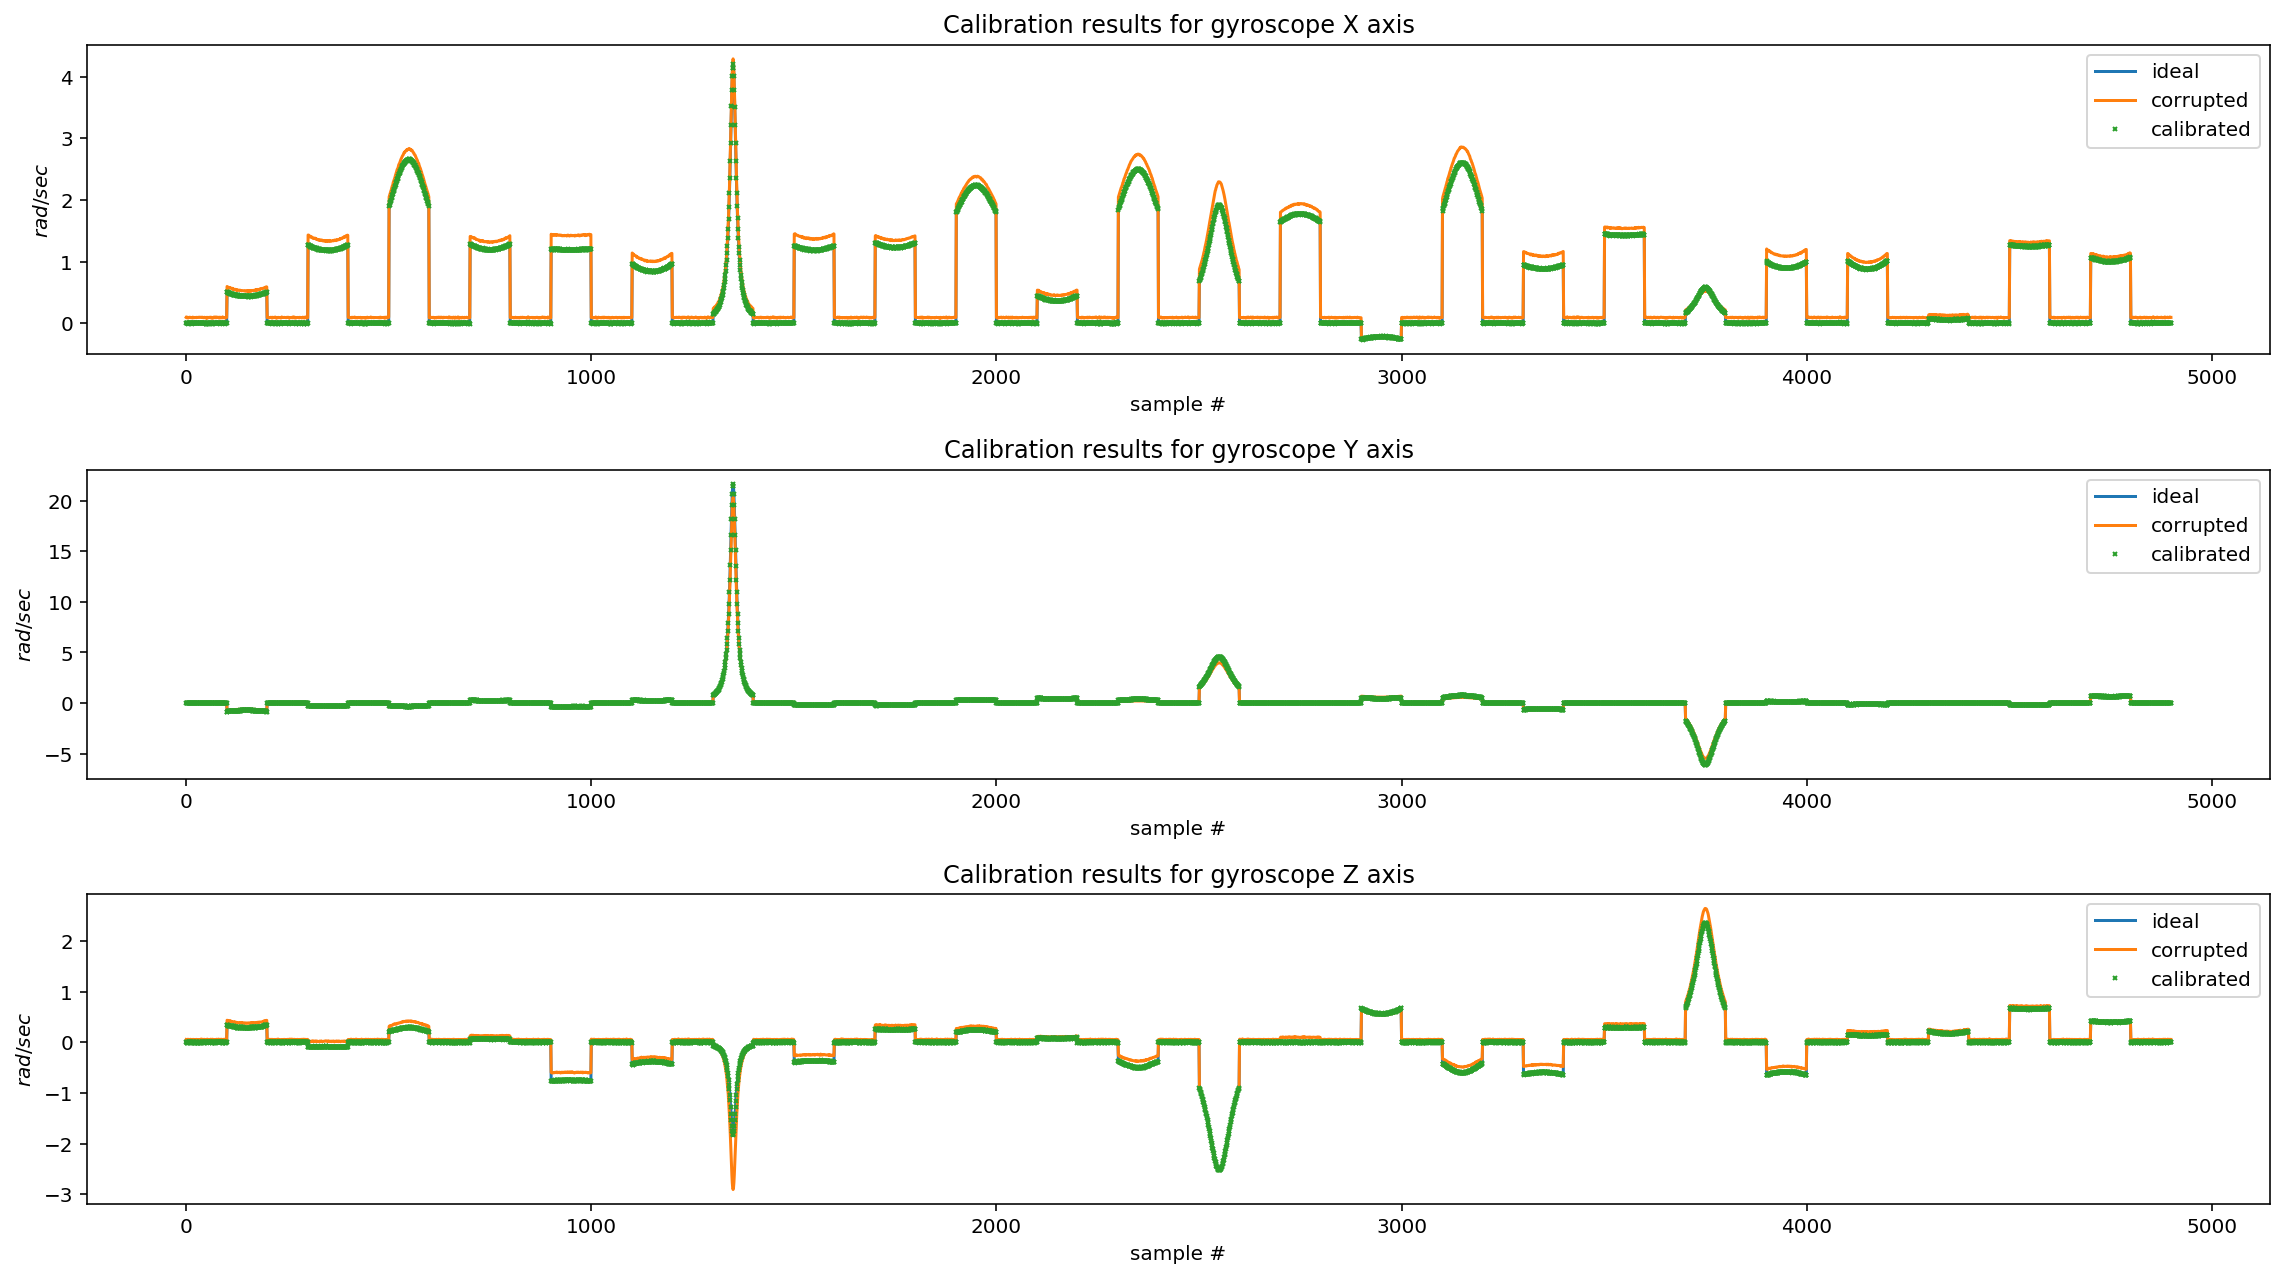

In [1]:
import numpy as np
from code.monte_carlo import monte_carlo_cycle

%config InlineBackend.figure_format='retina'
np.set_printoptions(edgeitems=30, linewidth=1000, formatter={'float': '{: 0.4f}'.format})

# Define sampling frequency
sampling_frequency = 100

# Set number of iterations
iterations_num = 1

# Whether or not randomize rotations
randomize = True


N_samples = sampling_frequency
dt = 1 / sampling_frequency
simulation_results = {}

for i in range(0, iterations_num):
    theta_acc = np.random.randint(100, size=9)  / np.array([1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 
                                                            1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 100* np.random.choice([-1,1]), 100* np.random.choice([-1,1]), 100* np.random.choice([-1,1])])
    theta_gyr = np.random.randint(100, size=12) / np.array([1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 
                                                            1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1]), 1000* np.random.choice([-1,1])])

    simulation_results[i] = monte_carlo_cycle(N_samples, dt, theta_acc, theta_gyr, randomize, plot = True)

## Calibrate real IMU

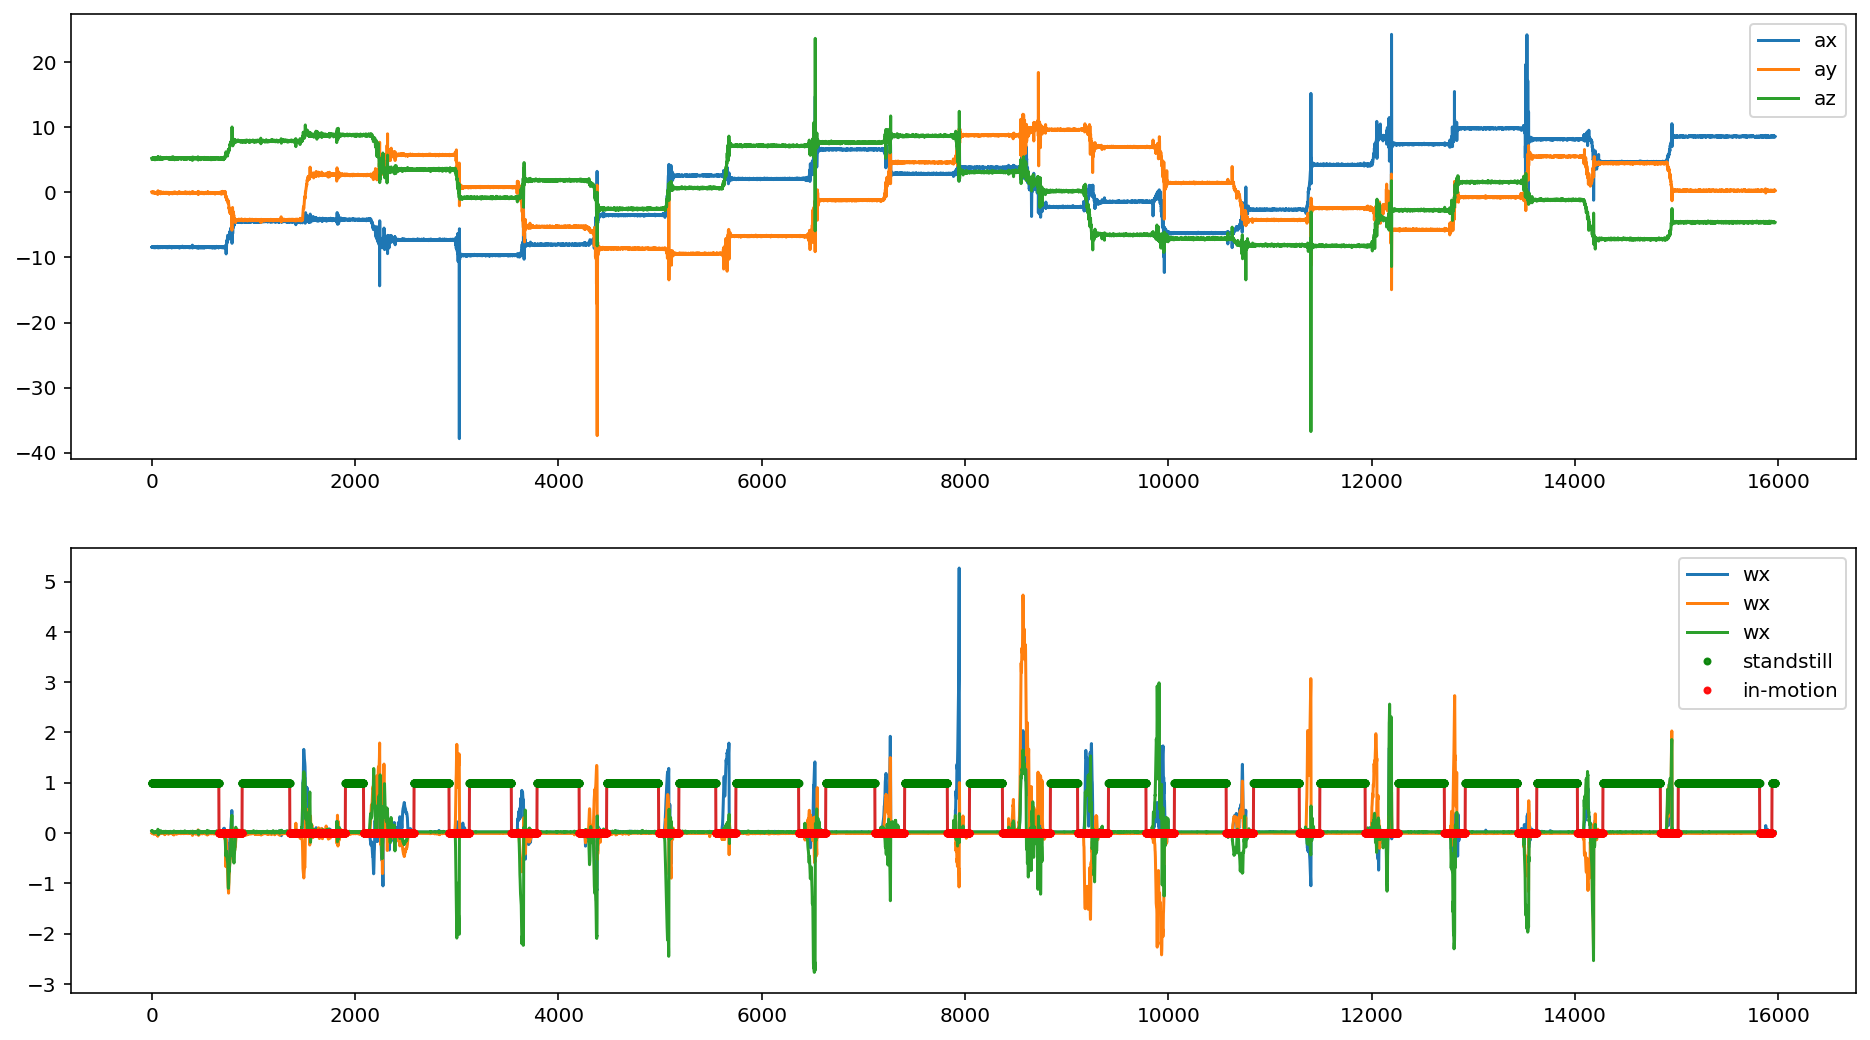

ACC calibration done in:  11.544180870056152 seconds
[ S_X     S_Y     S_Z     NO_X    NO_Y    NO_Z    B_X     B_Y     B_Z   ]
[ 0.0036  0.0032  0.0065  0.0021  0.0003  0.0055  0.1027  0.0967  0.3444]


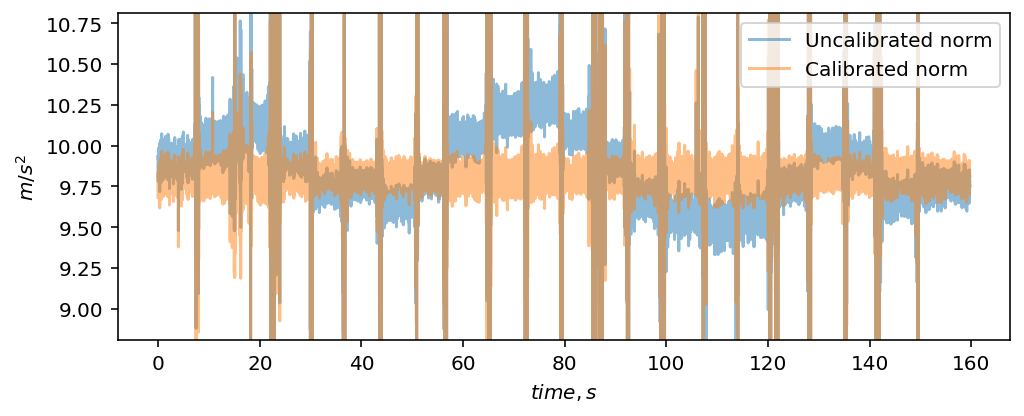

Gyroscope residuals before calibration:  12.919662455941541
GYR calibration done in:  29.457327365875244 seconds
[ S_X     S_Y     S_Z     NO_X    NO_Y    NO_Z    B_X     B_Y     B_Z     E_X     E_Y     E_Z  ]
[ 0.0002  0.0045  0.0082 -0.0006 -0.0023  0.0140  0.0196 -0.0067  0.0216  0.0005 -0.0063 -0.0014]
Gyroscope residuals after calibration:  0.2769345469880565


In [2]:
import numpy as np
import time

from code.simulator import *
from code.cost_functions import residual_acc, residual_gyr
from code.helpers import *
from code.utilities import *

sampling_frequency = 100
datafile = 'data/imu0.log'

dt = 1.0 / sampling_frequency

# read file with ax, ay, az, wx, wy, wz measurements from IMU
imu_data = np.genfromtxt(datafile, delimiter=' ')
standstill = generate_standstill_flags(imu_data)

plot_imu_data_and_standstill(imu_data, standstill)

accs, angs = imu_data[:,0:3], imu_data[:,3:6]

# find accelerometer calibration parameters and calibrate accel measurements
theta_found_acc = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
time_start = time.time()
theta_found_acc = find_calib_params_acc(True, residual_acc, theta_found_acc, accs, standstill > 0)
time_end = time.time()

print("ACC calibration done in: ", time_end - time_start, "seconds")
print("[ S_X     S_Y     S_Z     NO_X    NO_Y    NO_Z    B_X     B_Y     B_Z   ]")
print(theta_found_acc)
accs_calibrated = calibrate_accelerometer(accs, theta_found_acc)
plot_accelerations_before_and_after(accs, accs_calibrated)


# find gyroscope calibration parameters
theta_found_gyr = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
theta_found_gyr[-6:-3] = np.mean(angs[0:100,:], axis=0)

residualSum = lambda: np.sum(np.rad2deg(residual_gyr(theta_found_gyr, 
         angs, 
         accs_calibrated,
         standstill, dt))**2)

print("Gyroscope residuals before calibration: ", residualSum())
time_start = time.time()
theta_found_gyr = find_calib_params_gyr(True, residual_gyr, theta_found_gyr, 
    angs, accs_calibrated, standstill, 1.0/sampling_frequency)
time_end = time.time()
print("GYR calibration done in: ", time_end - time_start, "seconds")
print("[ S_X     S_Y     S_Z     NO_X    NO_Y    NO_Z    B_X     B_Y     B_Z     E_X     E_Y     E_Z  ]")
print(theta_found_gyr)
print("Gyroscope residuals after calibration: ", residualSum())